Enriching tower (benzene–toluene), saturated vapor feed (q=0)
F = 100 kmol/h, zF = 0.400000
xD = 0.900000, R = 4.000000, q = 0.000000

--- q-line and intersection ---
q-line: y = 0.400000
rectifying line: y = 0.800000 x + 0.180000
intersection (bottom of enriching section): xW = 0.275000, y = 0.400000

--- Products ---
D = 20 kmol/h, xD = 0.900000 (benzene)
W = 80 kmol/h, xW = 0.275000 (benzene)

--- Plates ---
Theoretical plates (enriching section) = 4.789
Ceiling integer plates = 5
Feed/bottom plate number from top = 5


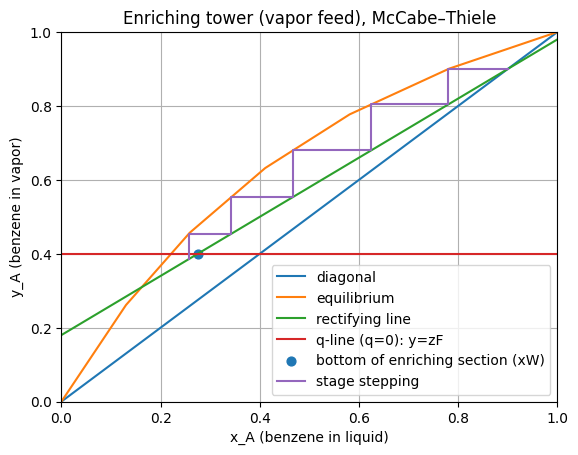

In [ ]:
# notebooks/26.4_7.py

import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, "..")

from bank.Distillation.distillation_mccabe_thiele_xy_base import (
    XYEquilibrium,
    rectifying_line_params,
    q_line_params,
    intersect_lines,
    step_off_stages_xy,
)

# ============================================================
# Given
# ============================================================
F = 100.0     # kmol/h (feed)
zF = 0.40     # benzene in feed (overall)
xD = 0.90     # benzene in distillate (liquid)
R  = 4.0      # reflux ratio
q  = 0.0      # saturated vapor feed

# Equilibrium data for benzene (light component)
x_eq = [1.000, 0.780, 0.581, 0.411, 0.258, 0.130, 0.000]
y_eq = [1.000, 0.900, 0.777, 0.632, 0.456, 0.261, 0.000]
eq = XYEquilibrium(x=x_eq, y=y_eq)

# ============================================================
# Enriching tower interpretation (no stripping section):
# - Only a rectifying (enriching) section is used.
# - The "bottoms" stream is taken at the feed plate / bottom of enriching section.
# - For saturated vapor feed (q=0), q-line is horizontal: y = zF.
# - The bottom-of-enriching-section liquid composition is the intersection of:
#       rectifying line  AND  q-line (y=zF)
#   That intersection x is used as xW (bottoms liquid composition).
# - Stage count: step from (xD,xD) down to xW using the rectifying line only.
# ============================================================

# Rectifying line: y = mR x + bR
mR, bR = rectifying_line_params(R, xD)

# q-line
mq, bq = q_line_params(q, zF)  # for q=0 -> slope 0, intercept zF

# Intersection between rectifying line and q-line
x_int, y_int = intersect_lines(mR, bR, mq, bq)

# For q=0, y_int should be zF
xW = x_int  # bottoms (liquid) composition at bottom of enriching section

# ============================================================
# Flows from overall/component balances using xW determined above:
#   F = D + W
#   F zF = D xD + W xW
# ============================================================
den = (xD - xW)
if abs(den) < 1e-14:
    raise ValueError("xD and xW too close; cannot solve balances.")

D = F * (zF - xW) / den
W = F - D

# Bottoms composition (liquid): xW
# Distillate composition (liquid): xD

# ============================================================
# Stage count: step off stages from top to xW using rectifying line only.
# Implement by setting both rect and strip lines equal to rect line and
# setting x_int arbitrarily (switch irrelevant because both lines identical).
# ============================================================
stepping = step_off_stages_xy(
    eq=eq,
    x_D=xD,
    x_W=xW,              # stop at the feed-point liquid composition
    rect=(mR, bR),
    strip=(mR, bR),      # same as rectifying => "rectifying only"
    x_int=0.5,           # irrelevant here
    max_stages=800,
)

N_steps_including_reboiler = stepping["N_theoretical"]
# For an enriching tower (no reboiler), report trays as "steps" (no reboiler subtraction).
N_theoretical_plates = N_steps_including_reboiler

# Feed plate location in an enriching-only tower:
# the last plate reached is the feed/bottom plate
# integer plate count (ceiling)
N_plates_ceiling = stepping["N_ceiling"]
feed_plate_from_top = N_plates_ceiling  # bottom of enriching section

# ============================================================
# Print results
# ============================================================
print("============================================================")
print("Enriching tower (benzene–toluene), saturated vapor feed (q=0)")
print("============================================================")
print(f"F = {F:.6g} kmol/h, zF = {zF:.6f}")
print(f"xD = {xD:.6f}, R = {R:.6f}, q = {q:.6f}")

print("\n--- q-line and intersection ---")
print(f"q-line: y = {zF:.6f}")
print(f"rectifying line: y = {mR:.6f} x + {bR:.6f}")
print(f"intersection (bottom of enriching section): xW = {xW:.6f}, y = {y_int:.6f}")

print("\n--- Products ---")
print(f"D = {D:.6g} kmol/h, xD = {xD:.6f} (benzene)")
print(f"W = {W:.6g} kmol/h, xW = {xW:.6f} (benzene)")

print("\n--- Plates ---")
print(f"Theoretical plates (enriching section) = {N_theoretical_plates:.3f}")
print(f"Ceiling integer plates = {N_plates_ceiling:d}")
print(f"Feed/bottom plate number from top = {feed_plate_from_top:d}")

# ============================================================
# Optional plot
# ============================================================
pts = np.array(stepping["points_xy"], dtype=float)

xs = np.linspace(0, 1, 500)
yeq = np.array([eq.y_of_x(float(x)) for x in xs])

plt.figure()
plt.plot(xs, xs, label="diagonal")
plt.plot(xs, yeq, label="equilibrium")
plt.plot(xs, mR * xs + bR, label="rectifying line")
plt.plot(xs, 0.0 * xs + zF, label="q-line (q=0): y=zF")
plt.scatter([xW], [zF], s=40, label="bottom of enriching section (xW)")
plt.plot(pts[:, 0], pts[:, 1], linewidth=1.5, label="stage stepping")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel("x_A (benzene in liquid)")
plt.ylabel("y_A (benzene in vapor)")
plt.title("Enriching tower (vapor feed), McCabe–Thiele")
plt.legend()
plt.show()